**NOTE**: data selection process occurs in the `fig1-pose-manifold-classifier` processing notebook; just loading the data here

In [1]:
import joblib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from aging.size_norm.util import multi_stage_pca, flatten
from toolz import valmap, compose
from sklearn.model_selection import (
    cross_val_score,
    StratifiedKFold,
    RepeatedStratifiedKFold,
    cross_val_predict,
    GridSearchCV, RandomizedSearchCV
)
from cuml.svm import LinearSVC
from cuml.preprocessing import StandardScaler, LabelEncoder
from cuml.ensemble import RandomForestClassifier
from cuml.pipeline import make_pipeline
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend
from sklearn.metrics import confusion_matrix, accuracy_score

In [2]:
c = PlotConfig()
format_plots()
saver = save_factory(c.save_path / "network-optim", tight_layout=False)

In [3]:
version = 12  # arhmm version
tmp = joblib.load(f'/n/scratch/users/w/wg41/aging-aligned-frames_version{version:02d}.p')
all_frames = tmp['frames']
all_recon_frames = tmp['recon']

## Decode age from frame

In [4]:
pipeline = make_pipeline(
    StandardScaler(),
    LinearSVC(class_weight='balanced'),
)

In [5]:
grid = GridSearchCV(
    pipeline,
    param_grid={"linearsvc__C": [0.01, 0.1, 0.5, 1, 5, 10, 100]},
    cv=StratifiedKFold(n_splits=4, shuffle=True, random_state=0)
)

### Original

In [6]:
pcs = multi_stage_pca(all_frames, subset_frames=400)

In [7]:
x = np.concatenate(list(pcs.values()), axis=0).astype('float32')
y = np.concatenate(list(map(lambda x: np.repeat(x[0][-1], len(x[1])), pcs.items())))

In [8]:
thinning = 3

new_x = x[::thinning]
new_y = y[::thinning]

In [9]:
grid.fit(new_x, new_y)

GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('linearsvc', LinearSVC())]),
             param_grid={'linearsvc__C': [0.01, 0.1, 0.5, 1, 5, 10, 100]})

In [10]:
col = np.unique(y)
add_cm = []
accs = []
for i in tqdm(range(50)):
    lr_preds = cross_val_predict(
        grid.best_estimator_,
        new_x,
        new_y,
        cv=StratifiedKFold(n_splits=4, shuffle=True, random_state=i),
    )
    cm = confusion_matrix(new_y, lr_preds, labels=col, normalize="pred")
    add_cm.append(cm)
    accs.append(accuracy_score(new_y, lr_preds))
raw_out = np.array(accs)

  0%|          | 0/50 [00:00<?, ?it/s]

In [11]:
cm_df = pd.DataFrame(np.mean(add_cm, axis=0), columns=col, index=col)

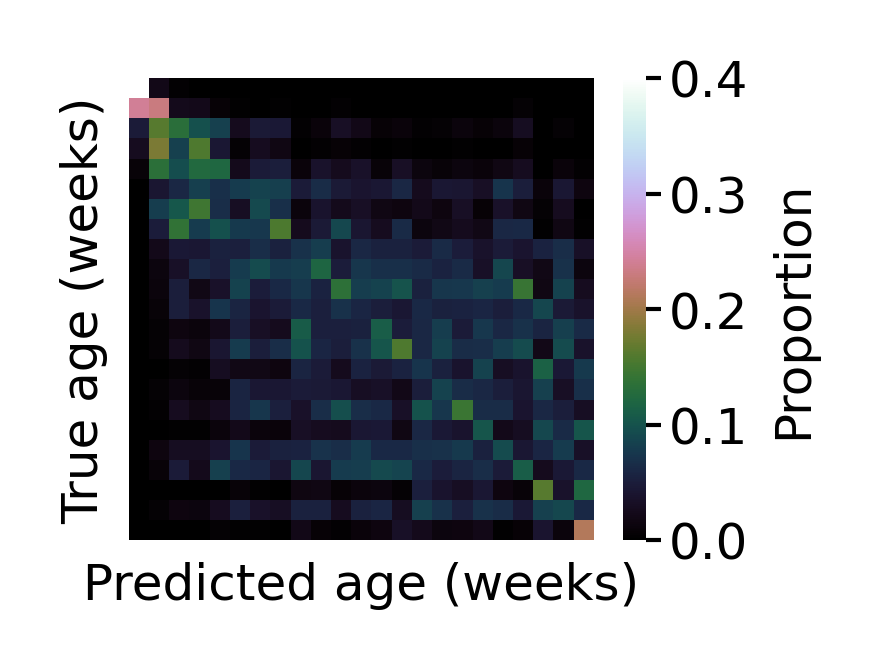

In [12]:
fig = figure(1.25, 1)
ax = sns.heatmap(
    cm_df,
    annot=False,
    cmap="cubehelix",
    cbar_kws=dict(label="Proportion"),
    vmax=0.4,
    vmin=0,
    xticklabels=False,
    yticklabels=False,
)
ax.set(xlabel='Predicted age (weeks)', ylabel='True age (weeks)')
saver(fig, 'original-pose-age-classification-confusion-mtx');

In [13]:
np.random.seed(0)
shuff_raw_out = []
for i in tqdm(range(15)):
    shuff_raw_out.extend(cross_val_score(
        pipeline,
        new_x,
        np.random.permutation(new_y),
        cv=StratifiedKFold(4),
    ))
shuff_raw_out = np.array(shuff_raw_out)

  0%|          | 0/15 [00:00<?, ?it/s]

### Transformed

In [14]:
recon_pcs = multi_stage_pca(all_recon_frames, subset_frames=400)

In [15]:
x = np.concatenate(list(recon_pcs.values()), axis=0).astype('float32')
y = np.concatenate(list(map(lambda x: np.repeat(x[0][-1], len(x[1])), recon_pcs.items())))

In [16]:
new_x = x[::thinning]
new_y = y[::thinning]

In [17]:
grid.fit(new_x, new_y)

GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('linearsvc', LinearSVC())]),
             param_grid={'linearsvc__C': [0.01, 0.1, 0.5, 1, 5, 10, 100]})

In [18]:
col = np.unique(y)
add_cm = []
accs = []
for i in tqdm(range(50)):
    lr_preds = cross_val_predict(
        grid.best_estimator_,
        new_x,
        new_y,
        cv=StratifiedKFold(n_splits=4, shuffle=True, random_state=i),
    )
    cm = confusion_matrix(new_y, lr_preds, labels=col, normalize="pred")
    add_cm.append(cm)
    accs.append(accuracy_score(new_y, lr_preds))
trans_out = np.array(accs)

  0%|          | 0/50 [00:00<?, ?it/s]

In [19]:
cm_df = pd.DataFrame(np.mean(add_cm, axis=0), columns=col, index=col)

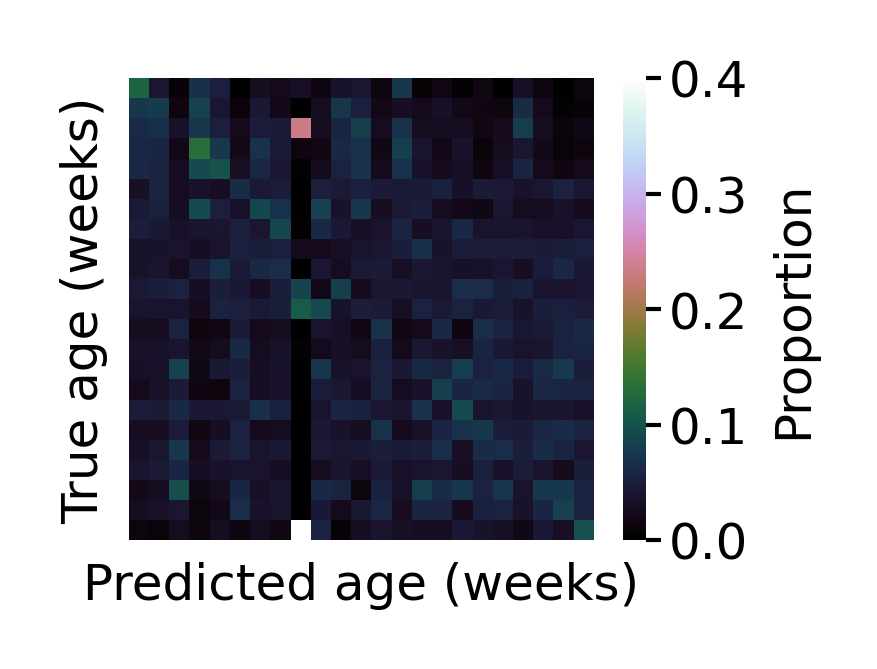

In [20]:
fig = figure(1.25, 1)
ax = sns.heatmap(
    cm_df,
    annot=False,
    cmap="cubehelix",
    cbar_kws=dict(label="Proportion"),
    vmax=0.4,
    vmin=0,
    xticklabels=False,
    yticklabels=False,
)
ax.set(xlabel='Predicted age (weeks)', ylabel='True age (weeks)')
saver(fig, 'transformed-pose-age-classification-confusion-mtx');

In [21]:
np.random.seed(0)
shuff_trans_out = []
for i in tqdm(range(15)):
    shuff_trans_out.extend(cross_val_score(
        pipeline,
        new_x,
        np.random.permutation(new_y),
        cv=StratifiedKFold(4),
    ))
shuff_trans_out = np.array(shuff_trans_out)

  0%|          | 0/15 [00:00<?, ?it/s]

### Accuracy comparison

In [22]:
outcomes = [
    pd.DataFrame(dict(acc=raw_out, treatment="Observed", type="Original")),
    pd.DataFrame(dict(acc=trans_out, treatment="Observed", type="Transformed")),
    pd.DataFrame(dict(acc=shuff_raw_out, treatment="Shuffle", type="Original")),
    pd.DataFrame(dict(acc=shuff_trans_out, treatment="Shuffle", type="Transformed")),
]
outcomes = pd.concat(outcomes, ignore_index=True)

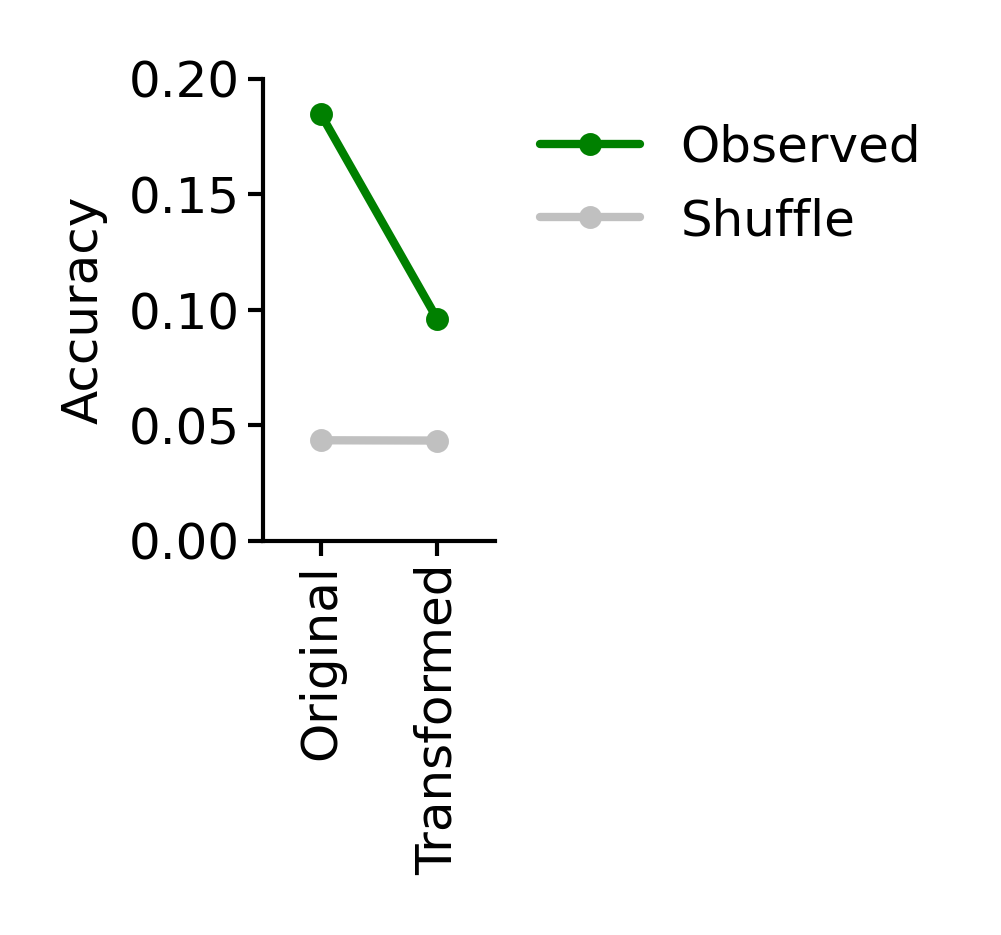

In [23]:
fig = figure(0.5, 1)
ax = sns.pointplot(
    data=outcomes,
    x="type",
    y="acc",
    palette=["green", "silver"],
    hue="treatment",
    hue_order=["Observed", "Shuffle"],
    errorbar=("sd", 2),
    markersize=2,
    linewidth=1,
)
ax.set(ylim=(0, 0.2), ylabel="Accuracy", xlabel="")
plt.xticks(rotation=90)
legend(ax)
sns.despine()
saver(fig, "age-decoder-from-pose-pointplot");

## Decode age from frame PC dynamics